In [2]:
import os
from shutil import copyfile
import subprocess
from save_embedded_graph27 import main_binary as embed_main
from spearmint_ghsom import main as ghsom_main
import numpy as np
import pickle
from time import time

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

#root dir
os.chdir("C:\Miniconda3\Jupyter\GHSOM_simplex_dsd")

#save directory
dir = os.path.abspath("parameter_tests")

#number of times to repeat
num_repeats = 10

#number of nodes in communitiy
s1 = 32

#number of links to same community
z1 = 16

#number of nodes in micro community
minc = s1
maxc = s1

#make save directory
if not os.path.isdir(dir):
    os.mkdir(dir)

#change to dir
os.chdir(dir)    

#network file names -- output of network generator
network = "network.dat"
first_level = "community.dat"

#community labels
labels = 'firstlevelcommunity'

#mixing parameter
z2 = 16

#node degree
k = z1 + z2
maxk = k

#mixing factors
mu = float(z2) / k 

num_communities = [3, 4, 5, 6]
parameter_settings = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

overall_nmi_scores = np.zeros((len(num_communities), len(parameter_settings), num_repeats))

for i in range(len(num_communities)):
# for k1 in num_communities:
    k1 = num_communities[i]
    
    #number of nodes in the network
    N = k1 * s1
    
    #create directory
    dir_string = os.path.join(dir, str(k1))
    if not os.path.isdir(dir_string):
        os.mkdir(dir_string)
    
    #change working directory    
    os.chdir(dir_string)
    
    for j in range(len(parameter_settings)):
#     for p in parameter_settings:
        
        p = parameter_settings[j]
        
        #ghsom parameters
        params = {'w': 0.0001,
                 'eta': 0.0001,
                 'sigma': 1,
                  'e_sg': p,
                 'e_en': 0.8}
    
        #create directory
        dir_string_p = os.path.join(dir_string, str(p))
        if not os.path.isdir(dir_string_p):
            os.mkdir(dir_string_p)
    
        #change working directory    
        os.chdir(dir_string_p)
        
        if os.path.isfile('nmi_scores.csv'):
            print 'already completed {}/{}, loading scores and continuing'.format(k1, p)
            nmi_scores = np.genfromtxt('nmi_scores.csv', delimiter=',')
            print nmi_scores
            overall_nmi_scores[i,j,:] = nmi_scores
            continue
        
        #copy executable
        ex = "benchmark.exe"   
        if not os.path.isfile(ex):

            source = "C:\\Users\\davem\\Documents\\PhD\\Benchmark Graph Generators\\binary_networks\\benchmark.exe"
            copyfile(source, ex)

        #make benchmark parameter file
        filename = "benchmark_flags_{}_{}.dat".format(k1,p)
        if not os.path.isfile(filename):
            with open(filename,"w") as f:
                f.write("-N {} -k {} -maxk {} -minc {} -maxc {} -mu {}".format(N, k, maxk, minc, maxc, mu))
            print 'written flag file: {}'.format(filename)
            
        #cmd strings
        change_dir_cmd = "cd {}".format(dir_string_p)
        generate_network_cmd = "benchmark -f {}".format(filename)

        #output of cmd
        output_file = open("cmd_output.out", 'w')

        #record NMI scores
        if not os.path.isfile('nmi_scores.pkl'):
            print 'creating new nmi scores array'
            nmi_scores = np.zeros(num_repeats)
        else:
            print 'loading nmi score progress'
            nmi_scores = load_obj('nmi_scores')

        #record running times
        if not os.path.isfile('running_times.pkl'):
            print 'creating new running time array'
            running_times = np.zeros(num_repeats)
        else:
            print 'loading running time progress'
            running_times = load_obj('running_times')
            
        print

        #generate networks
        for r in range(1, num_repeats+1):

            network_rename = "{}_{}".format(r,network)
            first_level_rename = "{}_{}".format(r,first_level)
            gml_filename = 'embedded_network_{}.gml'.format(r)

            if not os.path.isfile(network_rename):

                process = subprocess.Popen(change_dir_cmd + " && " + generate_network_cmd, 
                                        stdout=output_file, 
                                        stderr=output_file, 
                                        shell=True)
                process.wait()
                
                print 'generated graph {}'.format(r)

                os.rename(network, network_rename)
                os.rename(first_level, first_level_rename)
                
                print 'renamed graph {}'.format(r)

            if not os.path.isfile(gml_filename):

                ##embed graph
                embed_main(network_rename, first_level_rename)

                print 'embedded graph {} as {} in {}'.format(r, gml_filename, os.getcwd())

            ##score for this network
            if not np.all(nmi_scores[r-1]):

                start_time = time()

                print 'starting ghsom for: {}/{}/{}'.format(k1, p, gml_filename)
                nmi_score, communities_detected = ghsom_main(params, gml_filename, labels)
                nmi_scores[r-1] = nmi_score

                running_time = time() - start_time
                print 'running time of algorithm: {}'.format(running_time)
                running_times[r-1] = running_time

                #save
                save_obj(nmi_scores, 'nmi_scores')
                save_obj(running_times, 'running_times')

                print 'saved nmi score for network {}: {}'.format(gml_filename, nmi_score)
                print

        ##output nmi scores to csv file
        print 'writing nmi scores and running times to file'
        np.savetxt('nmi_scores.csv',nmi_scores,delimiter=',')
        np.savetxt('running_times.csv',running_times,delimiter=',')
        print
    
print 'DONE'

print 'OVERALL NMI SCORES'
print overall_nmi_scores

already completed 3/0.5, loading scores and continuing
[ 0.51757353  0.56056547  0.60567658  0.45671193  0.5714789   0.58880318
  0.58911933  0.67335987  0.59373086  0.51496481]
already completed 3/0.6, loading scores and continuing
[ 0.5853813   0.9576527   0.5094697   0.51942692  0.58030471  0.63681553
  0.58788973  0.53538522  0.54901159  0.55437548]
already completed 3/0.7, loading scores and continuing
[ 0.9576527   0.34382339  0.9576527   0.55674736  0.9576527   1.          0.3547282
  0.9576527   0.9576527   0.41377428]
already completed 3/0.8, loading scores and continuing
[ 0.9576527   0.47805403  0.9576527   0.58652295  0.60326795  1.
  0.67261035  0.9576527   0.9576527   0.45520928]
already completed 3/0.9, loading scores and continuing
[ 0.9576527   0.76437209  0.9576527   1.          0.9576527   0.9576527
  0.71365874  0.9576527   0.9576527   0.6616903 ]
already completed 3/1, loading scores and continuing
[ -4.99600361e-06   1.59495567e-02  -4.99600361e-06  -4.99600361e-0

In [11]:
for i in range(len(num_communities)):
    for j in range(len(parameter_settings)):
        
        scores = overall_nmi_scores[i,j]
    
#     print scores
#     idx = np.argsort(scores)[::-1]
    
#     print parameter_settings[idx[0]]
        print np.mean(scores)
    
        print np.std(scores) / np.sqrt(num_repeats)
        
        print
        
    print 

0.567198444804
0.0178501116833

0.601571287057
0.0391840090395

0.745733671068
0.086575386157

0.762627534848
0.0669689777595

0.88856373003
0.0372215835923

0.209163398679
0.0858497352418


0.899813019133
0.0312952500778

0.964696868751
0.00961496072104

0.977348734524
0.00238765302634

0.974831927249
5.55111512313e-17

0.842800127327
0.0149466887406

0.11947376088
0.077136851233


0.977712908606
0.00469094216289

0.981260361343
0.00132553300067

0.911573387588
0.0179574958586

0.946585997979
0.0197052513757

0.855596133891
0.0175698335708

0.207926289984
0.0866410517661


0.986918784315
0.00190757012402

0.952461832859
0.0147186866112

0.93105964482
0.0194982540751

0.952770488674
0.0147666155611

0.826949592739
0.0149971290199

0.334744249986
0.0871559984796




In [6]:
par = np.zeros(len(num_communities))
for i in range(len(num_communities)):
    
    means = np.zeros(len(parameter_settings))
    
    for j in range(len(parameter_settings)):
        
        scores = overall_nmi_scores[i,j]
        
        means[j] = np.mean(scores)
        
    idx = np.argsort(means)[::-1]
    
    par[i] = parameter_settings[idx[0]]
        


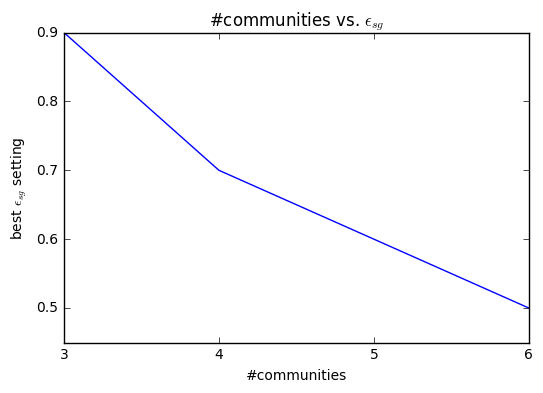

In [14]:
import matplotlib.pyplot as plt

plt.plot(num_communities, par, 'b')
# plt.axis([3, 6, 0.5, 1])
plt.xticks(np.arange(3,7,1))
plt.xlabel('#communities')
plt.ylabel('best $\epsilon_{sg}$ setting')
plt.title('#communities vs. $\epsilon_{sg}$')
plt.show()